In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

from data_reading import read_and_combine_csv
from feature_engineering import FeatureEngineer
from config import Config
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from dateutil.relativedelta import relativedelta

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
def calculate_15mins_sharpe_ratio_and_annualized_return(returns):
    """
    计算传入的15分钟频率的收益率数据的年化收益率和Sharpe Ratio
    参数:
    returns (pandas.Series): 已计算的收益率序列
    
    返回:
    dict: 包含年化收益率和Sharpe Ratio
    """
    # 计算收益率的标准差
    returns_std = returns.std()

    # 计算平均收益率
    mean_return = returns.mean()

    total_return = (1 + returns).prod() - 1
    print('total return:',total_return)
    # 年化收益率计算，15分钟频率下每年有 35040 个15分钟周期
    annualized_return = (1 + total_return) ** (35040 / len(returns)) - 1
    # Sharpe Ratio 计算，假设无风险收益率为 0
    sharpe_ratio = mean_return / returns_std * np.sqrt(35040)
    
    cumulative_returns = (1 + returns).cumprod()  # 计算累计收益
    rolling_max = cumulative_returns.cummax()  # 计算滚动最大值
    drawdown = (cumulative_returns - rolling_max) / rolling_max  # 计算回撤
    max_drawdown = drawdown.min() 
    
    return {
        'annualized_return': annualized_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown
    }

In [3]:
config = Config()
fe = FeatureEngineer()
fold_name = f'{config.symbols[7]}-spot-klines-15m-from_2018_to_2025'
df = read_and_combine_csv(f'./raw_data/{fold_name}')

正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2022-08.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2025-01.csv
读取文件失败: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2025-01.csv, 错误: year 56971 is out of range
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2018-09.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2018-08.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2022-09.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2020-08.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2020-09.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2019-02.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2021-06.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2021-12.csv
正在读取文件: ./raw_data/ETHUSDT-spot-k

In [4]:
df

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2018-01-01 08:00:00,733.01,734.52,722.91,727.31,420.84730,2018-01-01 08:14:59.999,3.062671e+05,867,210.68080,1.532772e+05,0
1,2018-01-01 08:15:00,727.22,728.44,720.03,725.51,586.88558,2018-01-01 08:29:59.999,4.250692e+05,890,351.73472,2.546975e+05,0
2,2018-01-01 08:30:00,725.51,728.61,722.85,723.38,522.11912,2018-01-01 08:44:59.999,3.794493e+05,654,298.03786,2.166539e+05,0
3,2018-01-01 08:45:00,723.33,727.62,722.50,727.62,576.04900,2018-01-01 08:59:59.999,4.177735e+05,703,414.77933,3.008165e+05,0
4,2018-01-01 09:00:00,727.01,728.25,723.00,724.64,320.34994,2018-01-01 09:14:59.999,2.324155e+05,474,122.04581,8.860470e+04,0
...,...,...,...,...,...,...,...,...,...,...,...,...
244937,2025-01-01 06:45:00,3344.07,3346.45,3329.00,3339.88,2793.12000,2025-01-01 06:59:59.999,9.324333e+06,15324,1411.93770,4.715837e+06,0
244938,2025-01-01 07:00:00,3339.88,3343.91,3328.47,3341.91,2654.69870,2025-01-01 07:14:59.999,8.859294e+06,22124,1374.34410,4.586771e+06,0
244939,2025-01-01 07:15:00,3341.91,3345.98,3335.52,3343.45,1130.91660,2025-01-01 07:29:59.999,3.778152e+06,13363,784.78810,2.621702e+06,0
244940,2025-01-01 07:30:00,3343.45,3344.25,3332.39,3339.06,1284.31850,2025-01-01 07:44:59.999,4.285603e+06,12596,630.57880,2.104125e+06,0


In [5]:
df.rename({'Close': 'close',
           'Open': 'open',
           'High': 'high',
           'Low': 'low',
           'Volume': 'volume'}, axis=1, inplace=True)

In [6]:
df = fe.process_data(df)
df['return_15m'] = df['close'].pct_change(1).shift(-1)
config.target_col = 'return_15m'

In [7]:
# 对收益率进行分箱
# 计算滚动波动率（过去 960 根 K 线，10 天）
# window_size = 960*3  # 可以调整这个窗口大小
# window_size = 960*2  # 可以调整这个窗口大小 #很烂

window_size = 960  # 可以调整这个窗口大小
# window_size = 10000  # 可以调整这个窗口大小
# window_size = 480  # 可以调整这个窗口大小 #很烂
# 很有效的一个因子
df['rolling_vol'] = df['return_15m'].rolling(window=window_size).std()#很有效的一个因子
df['rolling_vol']=df['rolling_vol'].shift(1)


# 避免最开始的 NaN
df.dropna(subset=['rolling_vol'], inplace=True)


# 使用滚动波动率进行分箱（使用一倍和二倍标准差作为分箱边界因为收益率通常被认为近似服从正态分布（尽管实际上有胖尾效应））

# def categorize_return(row):
#     if row['return_15m'] > 2 * row['rolling_vol']:
#         return 4  # 大涨
#     elif row['return_15m'] > row['rolling_vol']:
#         return 3  # 涨
#     elif row['return_15m'] > -row['rolling_vol']:
#         return 2  # 震荡
#     elif row['return_15m'] > -2 * row['rolling_vol']:
#         return 1  # 跌
#     else:
#         return 0  # 大跌

# df['return_class'] = df.apply(categorize_return, axis=1)

In [8]:
# 设定features
config.set_feature_cols(df)






In [9]:
df['time']=pd.to_datetime(df['Open time'])
start_date=dt.datetime(2022,1,1)
rolling_period =relativedelta(months=6)
end_date=start_date+rolling_period
df_final=pd.DataFrame()
while start_date<= max(df['time']):
    print(f'current trading date from {start_date} to {end_date} ')
    train=df[df['time']<start_date]
    test=df[(start_date<=df['time'])&(df['time']<end_date)]

    #打包
    # train, test = train_test_split(df, test_size=0.1, random_state=42, shuffle=False)

    scaler = StandardScaler()
    scaler_train = train.copy()
    scaler_test = test.copy()
    scaler_train[config.feature_cols] = scaler.fit_transform(train[config.feature_cols])
    scaler_test[config.feature_cols] = scaler.transform(test[config.feature_cols])

    # 时间序列 K 折交叉验证
    K = 5
    tscv = TimeSeriesSplit(n_splits=K)

    # 初始化 OOF 预测
    scaler_train['predicted_return'] = np.nan
    train['predicted_return'] = np.nan

    # # 训练 XGBoost 并生成 OOF 预测
    for train_index, val_index in tscv.split(train):
        train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]

        xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05, max_depth=6)
        xgb_model.fit(train_fold[config.feature_cols], train_fold[config.target_col])

        # 在验证集上预测，并填充到 train['predicted_return']
        scaler_train.loc[val_index, 'predicted_return'] = xgb_model.predict(val_fold[config.feature_cols])
        train.loc[val_index, 'predicted_return'] = scaler_train.loc[val_index, 'predicted_return']

    # 确保没有 NaN
    train.dropna(subset=['predicted_return'], inplace=True)
    scaler_train.dropna(subset=['predicted_return'], inplace=True)

    # 用完整 XGBoost 训练最终模型，并预测测试集
    xgb_model_final = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05, max_depth=6)
    xgb_model_final.fit(train[config.feature_cols], train[config.target_col])
    scaler_test['predicted_return'] = xgb_model_final.predict(test[config.feature_cols])
    test['predicted_return'] = scaler_test['predicted_return']

    # test['predicted_return']= xgb_model_final.predict(test[config.feature_cols])

    if(len(df_final)==0):
        df_final=test.copy()
    else:
        df_final=pd.concat([df_final,test])
    start_date = end_date
    end_date = start_date + rolling_period





current trading date from 2022-01-01 00:00:00 to 2022-07-01 00:00:00 
current trading date from 2022-07-01 00:00:00 to 2023-01-01 00:00:00 
current trading date from 2023-01-01 00:00:00 to 2023-07-01 00:00:00 
current trading date from 2023-07-01 00:00:00 to 2024-01-01 00:00:00 
current trading date from 2024-01-01 00:00:00 to 2024-07-01 00:00:00 
current trading date from 2024-07-01 00:00:00 to 2025-01-01 00:00:00 
current trading date from 2025-01-01 00:00:00 to 2025-07-01 00:00:00 


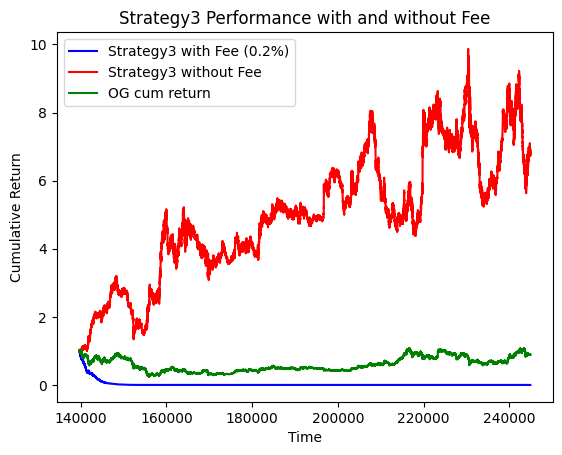

total return: 5.805850090574316
年化收益率: 0.8937
Sharpe Ratio: 1.2840
Max drawdown: -0.5812


In [15]:
# startegy 3，预测收益率明显大于交易费用是才交易
transaction_fee_single_side = 0.001
df_final['signal_3'] = df_final['predicted_return'].apply(
    lambda x: 1 if x > 0 * transaction_fee_single_side else (-1 if x < -0 * transaction_fee_single_side else 0))
df_final['position_3'] = df_final['signal_3'].replace(0, np.nan).ffill().fillna(0)
df_final['strategy3_return'] = df_final['position_3'] * df_final['return_15m']

df_final['position_3_change'] = df_final['position_3'].diff().fillna(df_final['position_3'].iloc[0])
df_final['strategy3_return_with_fee'] = df_final['position_3'] * df_final['return_15m']

# Apply the fee when there is a position change (from 1 to -1 or -1 to 1)
df_final['strategy3_return_with_fee'] = df_final['strategy3_return_with_fee'] - transaction_fee_single_side * abs(
    df_final['position_3_change'])

df_final['strategy3_return'] = df_final['position_3'] * df_final['return_15m']

df_final['strategy3_cum_return_with_fee'] = (1 + df_final['strategy3_return_with_fee']).cumprod()
df_final['strategy3_cum_return_without_fee'] = (1 + df_final['strategy3_return']).cumprod()
df_final['og_cum_return'] = (1 + df_final['return_15m']).cumprod()

plt.plot(df_final['strategy3_cum_return_with_fee'], label="Strategy3 with Fee (0.2%)", color='b')
plt.plot(df_final['strategy3_cum_return_without_fee'], label="Strategy3 without Fee", color='r')
plt.plot(df_final['og_cum_return'], label="OG cum return", color='g')
plt.legend()

plt.title('Strategy3 Performance with and without Fee')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.show()

strategy3_result = calculate_15mins_sharpe_ratio_and_annualized_return(df_final['strategy3_return'])

print(f"年化收益率: {strategy3_result['annualized_return']:.4f}")
print(f"Sharpe Ratio: {strategy3_result['sharpe_ratio']:.4f}")
print(f"Max drawdown: {strategy3_result['max_drawdown']:.4f}")



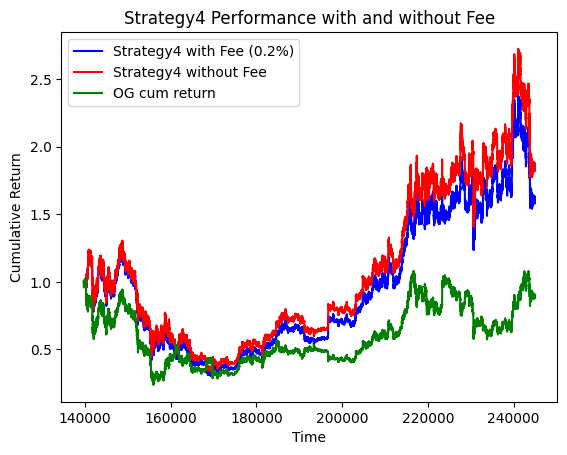

total return: 0.8682141933579195
年化收益率: 0.2313
Sharpe Ratio: 0.6455
Max drawdown: -0.7404


In [11]:
# startegy 4，预测收益率明显大于交易费用是才交易
transaction_fee_single_side = 0.001
df_final['signal_4'] = df_final['predicted_return'].apply(
    lambda x: 1 if x > 4 * transaction_fee_single_side else (-1 if x < -4 * transaction_fee_single_side else 0))
df_final['position_4'] = df_final['signal_4'].replace(0, np.nan).ffill().fillna(0)
df_final['strategy4_return'] = df_final['position_4'] * df_final['return_15m']

df_final['position_4_change'] = df_final['position_4'].diff().fillna(df_final['position_4'].iloc[0])
df_final['strategy4_return_with_fee'] = df_final['position_4'] * df_final['return_15m']

# Apply the fee when there is a position change (from 1 to -1 or -1 to 1)
df_final['strategy4_return_with_fee'] = df_final['strategy4_return_with_fee'] - transaction_fee_single_side * abs(
    df_final['position_4_change'])

df_final['strategy4_return'] = df_final['position_4'] * df_final['return_15m']

df_final['strategy4_cum_return_with_fee'] = (1 + df_final['strategy4_return_with_fee']).cumprod()
df_final['strategy4_cum_return_without_fee'] = (1 + df_final['strategy4_return']).cumprod()
df_final['og_cum_return'] = (1 + df_final['return_15m']).cumprod()

plt.plot(df_final['strategy4_cum_return_with_fee'], label="Strategy4 with Fee (0.2%)", color='b')
plt.plot(df_final['strategy4_cum_return_without_fee'], label="Strategy4 without Fee", color='r')
plt.plot(df_final['og_cum_return'], label="OG cum return", color='g')
plt.legend()

plt.title('Strategy4 Performance with and without Fee')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.show()

strategy4_result = calculate_15mins_sharpe_ratio_and_annualized_return(df_final['strategy4_return'])

print(f"年化收益率: {strategy4_result['annualized_return']:.4f}")
print(f"Sharpe Ratio: {strategy4_result['sharpe_ratio']:.4f}")
print(f"Max drawdown: {strategy4_result['max_drawdown']:.4f}")

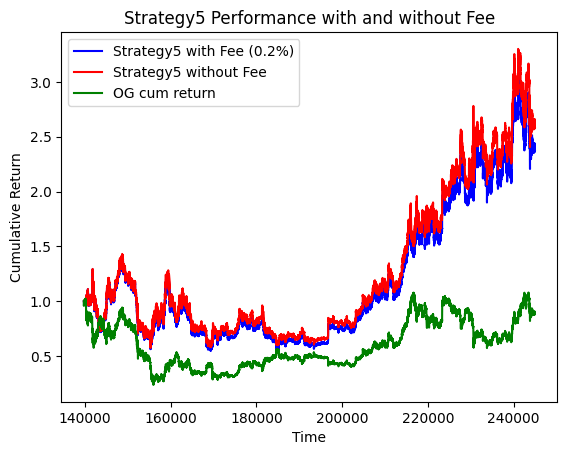

total return: 1.5869252920970904
年化收益率: 0.3723
Sharpe Ratio: 0.8065
Max drawdown: -0.5981


In [12]:
# startegy 5，预测收益率明显大于交易费用是才交易
transaction_fee_single_side = 0.001
df_final['signal_5'] = df_final['predicted_return'].apply(
    lambda x: 1 if x > 5 * transaction_fee_single_side else (-1 if x < -5 * transaction_fee_single_side else 0))
df_final['position_5'] = df_final['signal_5'].replace(0, np.nan).ffill().fillna(0)
df_final['strategy5_return'] = df_final['position_5'] * df_final['return_15m']

df_final['position_5_change'] = df_final['position_5'].diff().fillna(df_final['position_5'].iloc[0])
df_final['strategy5_return_with_fee'] = df_final['position_5'] * df_final['return_15m']

# Apply the fee when there is a position change (from 1 to -1 or -1 to 1)
df_final['strategy5_return_with_fee'] = df_final['strategy5_return_with_fee'] - transaction_fee_single_side * abs(
    df_final['position_5_change'])

df_final['strategy5_return'] = df_final['position_5'] * df_final['return_15m']

df_final['strategy5_cum_return_with_fee'] = (1 + df_final['strategy5_return_with_fee']).cumprod()
df_final['strategy5_cum_return_without_fee'] = (1 + df_final['strategy5_return']).cumprod()
df_final['og_cum_return'] = (1 + df_final['return_15m']).cumprod()

plt.plot(df_final['strategy5_cum_return_with_fee'], label="Strategy5 with Fee (0.2%)", color='b')
plt.plot(df_final['strategy5_cum_return_without_fee'], label="Strategy5 without Fee", color='r')
plt.plot(df_final['og_cum_return'], label="OG cum return", color='g')
plt.legend()

plt.title('Strategy5 Performance with and without Fee')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.show()

strategy5_result = calculate_15mins_sharpe_ratio_and_annualized_return(df_final['strategy5_return'])

print(f"年化收益率: {strategy5_result['annualized_return']:.4f}")
print(f"Sharpe Ratio: {strategy5_result['sharpe_ratio']:.4f}")
print(f"Max drawdown: {strategy5_result['max_drawdown']:.4f}")

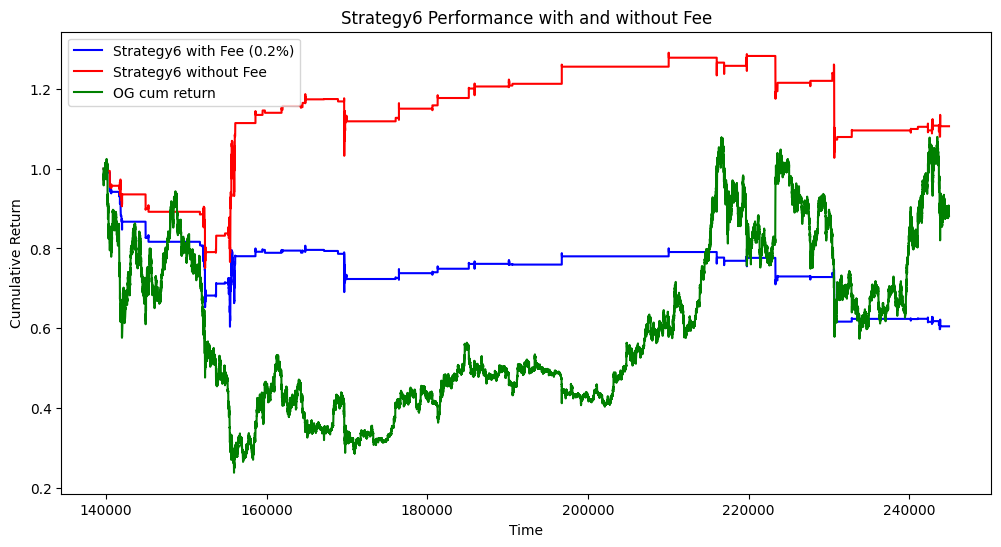

total return: -0.39523040429680967
年化收益率: -0.1542
Sharpe Ratio: -0.7682
Max drawdown: -0.4024


In [13]:
# Initialize position list with correct indexing
position_6 = [0]  # Start with no position

# Get DataFrame index list
index_list = df_final.index.tolist()

# Loop through predicted returns to determine position changes
for i in range(1, len(index_list)):
    idx = index_list[i]  # Current index
    prev_idx = index_list[i - 1]  # Previous index

    prev_position = position_6[-1]  # Last stored position
    pred_ret = df_final.at[idx, 'predicted_return']

    # Entry signals
    if pred_ret > 4 * transaction_fee_single_side:
        position_6.append(1)  # Enter long
    elif pred_ret < -4 * transaction_fee_single_side:
        position_6.append(-1)  # Enter short
    # Stop loss conditions
    elif prev_position == 1 and pred_ret < 0:
        position_6.append(0)  # Stop loss from long
    elif prev_position == -1 and pred_ret > 0:
        position_6.append(0)  # Stop loss from short
    else:
        position_6.append(prev_position)  # Hold previous position

# Assign position values to the correct DataFrame index
df_final.loc[index_list, 'position_6'] = position_6

# Compute strategy return
df_final['strategy6_return'] = df_final['position_6'] * df_final['return_15m']

# Identify position changes for fee application
df_final['position_6_change'] = df_final['position_6'].diff().fillna(df_final['position_6'].iloc[0])

# Compute strategy return with fees
df_final['strategy6_return_with_fee'] = df_final['strategy6_return'] - (2 * transaction_fee_single_side) * (df_final['position_6_change'] != 0)

# Compute cumulative returns
df_final['strategy6_cum_return_with_fee'] = (1 + df_final['strategy6_return_with_fee']).cumprod()
df_final['strategy6_cum_return_without_fee'] = (1 + df_final['strategy6_return']).cumprod()
df_final['og_cum_return'] = (1 + df_final['return_15m']).cumprod()

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df_final['strategy6_cum_return_with_fee'], label="Strategy6 with Fee (0.2%)", color='b')
plt.plot(df_final['strategy6_cum_return_without_fee'], label="Strategy6 without Fee", color='r')
plt.plot(df_final['og_cum_return'], label="OG cum return", color='g')
plt.legend()
plt.title('Strategy6 Performance with and without Fee')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.show()

# Calculate performance metrics
strategy6_result = calculate_15mins_sharpe_ratio_and_annualized_return(df_final['strategy6_return_with_fee'])

print(f"年化收益率: {strategy6_result['annualized_return']:.4f}")
print(f"Sharpe Ratio: {strategy6_result['sharpe_ratio']:.4f}")
print(f"Max drawdown: {strategy6_result['max_drawdown']:.4f}")

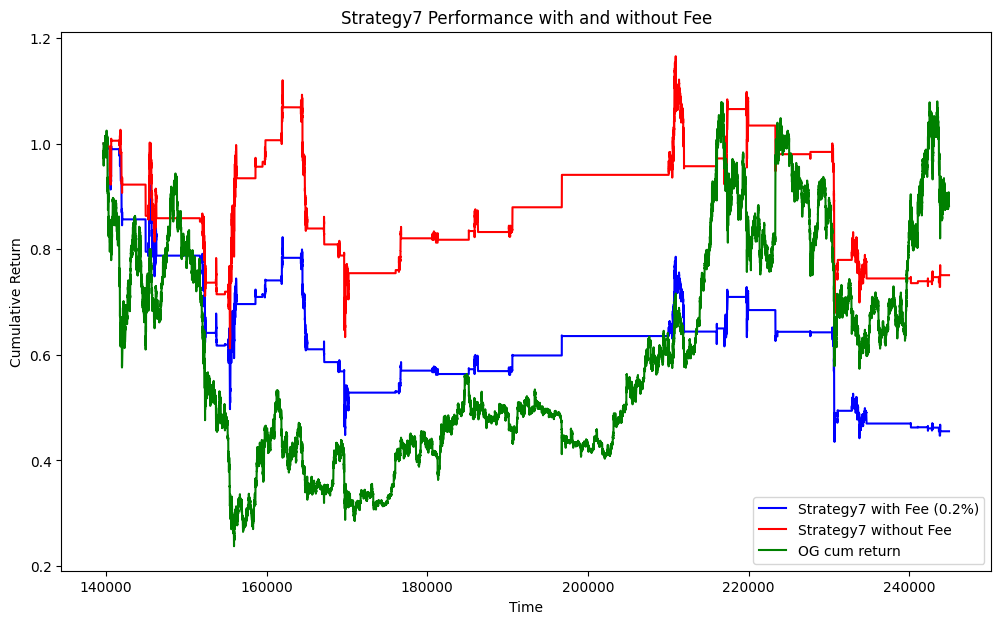

total return: -0.5447861889321469
年化收益率: -0.2305
Sharpe Ratio: -0.6918
Max drawdown: -0.5649


In [14]:
# Initialize position list with correct indexing
position_7 = [0]  # Start with no position

# Get DataFrame index list
index_list = df_final.index.tolist()

# Loop through predicted returns to determine position changes
for i in range(1, len(index_list)):
    idx = index_list[i]  # Current index
    prev_idx = index_list[i - 1]  # Previous index

    prev_position = position_7[-1]  # Last stored position
    pred_ret = df_final.at[idx, 'predicted_return']

    # Entry signals
    if pred_ret > 4 * transaction_fee_single_side:
        position_7.append(1)  # Enter long
    elif pred_ret < -4 * transaction_fee_single_side:
        position_7.append(-1)  # Enter short
    # Stop loss conditions
    elif prev_position == 1 and pred_ret < -1*transaction_fee_single_side:
        position_7.append(0)  # Stop loss from long
    elif prev_position == -1 and pred_ret > transaction_fee_single_side:
        position_7.append(0)  # Stop loss from short
    else:
        position_7.append(prev_position)  # Hold previous position

# Assign position values to the correct DataFrame index
df_final.loc[index_list, 'position_7'] = position_7

# Compute strategy return
df_final['strategy7_return'] = df_final['position_7'] * df_final['return_15m']

# Identify position changes for fee application
df_final['position_7_change'] = df_final['position_7'].diff().fillna(df_final['position_7'].iloc[0])

# Compute strategy return with fees
df_final['strategy7_return_with_fee'] = df_final['strategy7_return'] - (2 * transaction_fee_single_side) * (
            df_final['position_7_change'] != 0)

# Compute cumulative returns
df_final['strategy7_cum_return_with_fee'] = (1 + df_final['strategy7_return_with_fee']).cumprod()
df_final['strategy7_cum_return_without_fee'] = (1 + df_final['strategy7_return']).cumprod()
df_final['og_cum_return'] = (1 + df_final['return_15m']).cumprod()

# Plot results
plt.figure(figsize=(12, 7))
plt.plot(df_final['strategy7_cum_return_with_fee'], label="Strategy7 with Fee (0.2%)", color='b')
plt.plot(df_final['strategy7_cum_return_without_fee'], label="Strategy7 without Fee", color='r')
plt.plot(df_final['og_cum_return'], label="OG cum return", color='g')
plt.legend()
plt.title('Strategy7 Performance with and without Fee')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.show()

# Calculate performance metrics
strategy7_result = calculate_15mins_sharpe_ratio_and_annualized_return(df_final['strategy7_return_with_fee'])

print(f"年化收益率: {strategy7_result['annualized_return']:.4f}")
print(f"Sharpe Ratio: {strategy7_result['sharpe_ratio']:.4f}")
print(f"Max drawdown: {strategy7_result['max_drawdown']:.4f}")